# Fake News Detection

## Topic Modelling

***
The datasets used in this project are open source and freely available online. The data includes both fake and real news articles from multiple domains. The real news articles published contain true description of real world events, while the fake news websites contain claims that are not aligned with facts. The conformity of claims from the politics domain for many of those articles can be manually checked with fact checking websites such as politifact.com and snopes.com. Multiple different datasets are used here:

- The first dataset is called the “ISOT Fake News Dataset” (ds_1) which contains both true and fake articles extracted from the World Wide Web. The true articles are extracted from reuters.com which is a re-nowned news website, while the fake articles were extracted from multiple sources, mostly websites which are flagged by politifact.com. The dataset contains a total of 44,898 articles, out of which 21,417 are truthful articles and 23,481 fake articles. The total corpora contain articles from different domains, but most prominently target political news.
- The second dataset is available at Kaggle (ds_2) and contains a total of 20,386 articles used for training and 5,126 articles used for testing. The dataset is built from multiple sources on the Internet. The articles are not limited to a single domain such as politics as they include both fake and true articles from various other domains.
- The third dataset is also available at Kaggle (ds_3) and includes a total of 3,352 articles, both fake and true. The true articles are extracted from trusted online sources such as CNN, Reuters, the New York Times, and various others, while the fake news articles are extracted from untrusted news websites. The domains it covered include sports, entertainment, and politics.

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
import multiprocessing
import time

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
# !pip install emoji
# !pip install bs4
# from bs4 import BeautifulSoup

from wordcloud import WordCloud 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('dataset_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [3]:
df.head()

,text,label,char_count,word_count,avg_word,avg_text
0,following transcript donald trumps interview tuesday reporters editors opinion columnists the new york times the transcription prepare liam stack jonah engel bromwich karen workman tim herrera the...,0,39127,6540,4.982875,32588
1,fidel castro fiery apostle revolution bring cold war western hemisphere defy united states nearly half century cubas maximum leader bedevil american presidents briefly push world brink nuclear war...,0,32952,4765,5.915635,28188
2,for last hour american gunship circle high city carefully observe target vision sensors wait clearance strike it morning oct kunduz city envelop total darkness the citys power go five days soon ta...,0,32672,4685,5.973959,27988
3,presidentelect donald trumps first televised interview video cbs minutes trump talks wall deportations roe wade clintons future minutes interview november audio lesley stahl well congratulations m...,1,27033,4548,4.944151,22486
4,presidentelect donald trumps first televised interview video cbs minutes trump talks wall deportations roe wade clintons future minutes interview november audio lesley stahl well congratulations m...,1,27033,4548,4.944151,22486


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
# Convert to list
data = df.text.values.tolist()

In [6]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

In [7]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [8]:
# Remove single quotes
data = [re.sub("\'", "", sent) for sent in data]

***
**Tokenize words and Clean-up text**
***


In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

***
**Creating Bigram and Trigram Models**
***

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [11]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

***
**Remove Stopwords, Make Bigrams and Lemmatize**
***

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [14]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [15]:
# Initialize spacy 
nlp = spacy.load("en_core_web_sm")

In [16]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

***
**Create the Dictionary and Corpus needed for Topic Modeling**
***

The main inputs to the LDA topic model are the dictionary and the corpus. 

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [18]:
# Create Corpus
texts = data_lemmatized

In [19]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

***
**Building the Topic Model**
***

For the LDA Model: 
- alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.
- chunksize is the number of documents to be used in each training chunk. 
- update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
import pickle
pickle.dump(lda_model, open("lda_model.pkl", "wb"))

In [21]:
import pickle
lda_model = pickle.load(open("lda_model.pkl", "rb"))

***
**View the topics in LDA model**
***

The LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weight (importance) to the topic.

In [22]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"say" + 0.027*"report" + 0.024*"reuter" + 0.020*"source" + '
  '0.017*"washington" + 0.016*"department" + 0.013*"state" + 0.012*"official" '
  '+ 0.011*"russian" + 0.011*"committee"'),
 (1,
  '0.107*"woman" + 0.019*"mr" + 0.007*"ivanka" + 0.007*"rape" + 0.007*"kelly" '
  '+ 0.006*"ms" + 0.005*"husband" + 0.005*"chelsea" + 0.004*"sexual" + '
  '0.004*"female"'),
 (2,
  '0.022*"drug" + 0.016*"health" + 0.015*"cancer" + 0.012*"medical" + '
  '0.011*"water" + 0.011*"food" + 0.008*"hospital" + 0.006*"treatment" + '
  '0.005*"disorder" + 0.005*"organic"'),
 (3,
  '0.032*"room" + 0.027*"day" + 0.017*"light" + 0.016*"red" + 0.015*"blue" + '
  '0.015*"chat" + 0.015*"long" + 0.011*"guest" + 0.009*"say" + 0.008*"year"'),
 (4,
  '0.035*"army" + 0.029*"kill" + 0.029*"say" + 0.019*"syria" + 0.017*"state" + '
  '0.016*"reuter" + 0.016*"military" + 0.015*"force" + 0.013*"attack" + '
  '0.012*"islamic"'),
 (5,
  '0.051*"say" + 0.037*"reuter" + 0.020*"government" + 0.019*"tell" + '
  '0.01

This means for example that the top 10 keywords that contribute to topic 19 are: ‘system’, ‘study’, ‘google’.. and so on and the weight of ‘system’ on topic 0 is 0.082.

The weights reflect how important a keyword is to that topic.

***
**Compute Model Perplexity and Coherence Score**
***

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 

***
**Optimal number of topics for LDA**
***

One approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.


Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If we see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -10.667311865340974


In [24]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5223478417080543


***
**Visualize the topics-keywords**
***

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.272802 -0.285729       1        1  26.983401
3      0.135312 -0.163252       2        1  10.847666
5      0.292342  0.119091       3        1  10.255707
7      0.116032  0.016556       4        1   8.913126
15     0.212607  0.100376       5        1   7.368106
0      0.161244  0.113800       6        1   6.918107
6      0.011921  0.033126       7        1   4.466507
4      0.091786  0.091497       8        1   4.293923
12    -0.068585 -0.085274       9        1   3.842344
8      0.008451 -0.007120      10        1   3.411837
10    -0.033757  0.027788      11        1   3.023764
13     0.057318  0.128930      12        1   2.327724
17    -0.049291 -0.104188      13        1   2.023937
11    -0.129359  0.008924      14        1   1.225730
9     -0.165681 -0.018471      15        1   1.206562
1     -0.187979  0.001935      16        1   0.889133
19    -0.174765 -0.004153      17        1   0.802435
2     -0.181746 -0.001999      18        1   0.656952
14    -0.186166  0.013594      19        1   0.302466
16    -0.182486  0.014569      20        1   0.240572, topic_info=           Term           Freq          Total Category  logprob  loglift
971       trump  121690.000000  121690.000000  Default  30.0000  30.0000
719   president   73768.000000   73768.000000  Default  29.0000  29.0000
256      donald   52707.000000   52707.000000  Default  28.0000  28.0000
818         say  199756.000000  199756.000000  Default  27.0000  27.0000
411     hillary   23978.000000   23978.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
598        move     109.289506    9037.432887  Topic20  -5.5371   1.6148
7048    reverse      33.878529     729.176972  Topic20  -6.7084   2.9608
3213     muslim      47.979989    7729.480383  Topic20  -6.3604   0.9479
151        city      50.353349   11572.081967  Topic20  -6.3121   0.5926
174     condemn      28.111047    1106.561645  Topic20  -6.8950   2.3571

[1164 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9805      1  0.007646   abedin
9805      2  0.007646   abedin
9805      3  0.007646   abedin
9805      4  0.007646   abedin
9805      5  0.007646   abedin
...     ...       ...      ...
4033      8  0.049243  zionist
4033      9  0.049243  zionist
4033     10  0.049243  zionist
4033     11  0.049243  zionist
4033     20  0.492435  zionist

[11821 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 4, 6, 8, 16, 1, 7, 5, 13, 9, 11, 14, 18, 12, 10, 2, 20, 3, 15, 17])

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=40, step=5)

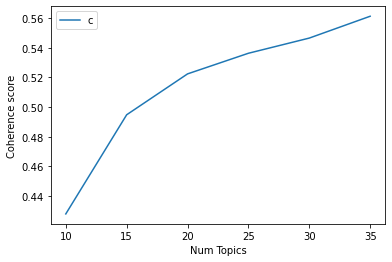

In [28]:
limit=40; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4279
Num Topics = 15  has Coherence Value of 0.4948
Num Topics = 20  has Coherence Value of 0.5223
Num Topics = 25  has Coherence Value of 0.5363
Num Topics = 30  has Coherence Value of 0.5465
Num Topics = 35  has Coherence Value of 0.5612


In [30]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(19,
  '0.036*"madrid" + 0.005*"la" + 0.004*"el" + 0.004*"foster" + 0.003*"warren" '
  '+ 0.003*"et" + 0.003*"die" + 0.002*"que" + 0.002*"santiago" + '
  '0.002*"commit_suicide"'),
 (1,
  '0.028*"mr" + 0.009*"ms" + 0.005*"mrs" + 0.002*"owen" + 0.002*"cooper" + '
  '0.002*"mo" + 0.001*"dubai" + 0.001*"nonprofit_organization" + 0.001*"cuomo" '
  '+ 0.001*"del"'),
 (4,
  '0.050*"syria" + 0.035*"syrian" + 0.022*"lebanon" + 0.016*"war" + '
  '0.014*"united" + 0.011*"un" + 0.011*"saudi" + 0.010*"conflict" + '
  '0.010*"lebanese" + 0.010*"peace"'),
 (2,
  '0.024*"drug" + 0.019*"health" + 0.017*"cancer" + 0.017*"water" + '
  '0.015*"shortage" + 0.014*"food" + 0.013*"medical" + 0.008*"hospital" + '
  '0.008*"dr" + 0.007*"eat"'),
 (14,
  '0.027*"mexico" + 0.020*"immigration" + 0.019*"country" + 0.019*"travel" + '
  '0.018*"border" + 0.017*"refugee" + 0.014*"wall" + 0.013*"illegal" + '
  '0.012*"mexican" + 0.012*"arrival"'),
 (22,
  '0.017*"chart" + 0.011*"study" + 0.010*"earth" + 0.008*"polluti

***
**Finding the dominant topic in each sentence**
***

One of the practical application of topic modeling is to determine what topic a given document is about. To find that, we find the topic number that has the highest percentage contribution in that document.

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [32]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

In [33]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

***
**Find the most representative document for each topic**
***

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. 

In [34]:
# Group top sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                            grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [35]:
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7360,"report, source, say, reuter, department, security, committee, official, investigation, intelligence",washington reuters us representative adam schiff top democrat house representatives intelligence committee say monday committees chairman recuse involvement panel investigation russian involvement...
1,1.0,0.1988,"mr, ms, mrs, owen, cooper, mo, dubai, nonprofit_organization, cuomo, del",al qaeda reivindica la rotura del retrovisor de un bmw ci el recambio tardar semanas en llegar este sitio web utiliza cookies para analizar cmo es utilizado el sitio las cookies te pueden identifi...
2,2.0,0.4030,"drug, health, cancer, water, shortage, food, medical, hospital, dr, eat",should people mental illness help die adam maierclayton condition cause body feel severe physical pain he fight right die canada
3,3.0,0.7202,"room, list, day, light, red, blue, long, big, october, photo",news bulletin bayern munich players celebrate philipp lahm score open goal german cup dfb pokal second round football match fc bayern munich fc augsburg munich southern germany october afp german ...
4,4.0,0.3767,"syria, syrian, lebanon, war, united, un, saudi, conflict, lebanese, peace",beirut reuters saudi arabia say monday lebanon declare war attack kingdom lebanese shi ite group hezbollah saudi gulf affairs minister thamer alsabhan tell alarabiya tv saad alhariri announce resi...


***
**Topic distribution across documents**
***

Understand the volume and distribution of topics in order to judge how widely it was discussed.

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,15.0,"video, happen, get, great, go, people, make, know, think, tell",2127.0,0.0392
1.0,7.0,"say, reuter, washington, state, government, law, list, administration, system, thursday",2.0,0.0000
2.0,17.0,"army, kill, government, say, military, attack, state, force, islamic, turkey",20.0,0.0004
3.0,15.0,"video, happen, get, great, go, people, make, know, think, tell",949.0,0.0175
4.0,15.0,"video, happen, get, great, go, people, make, know, think, tell",13.0,0.0002


***
**Term-Topic Matrix**
***

In [37]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=20)] for n in range(0, lda_model.num_topics)]

In [38]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,say,woman,drug,room,army,say,election,company,police,johnson,law,hillary,black,republican,fbi,trump,israel,news,happen,system
Term2,report,mr,health,day,kill,reuter,vote,say,say,movie,rule,clinton,muslim,bill,fbi_director,president,capital,comment,video,study
Term3,reuter,ivanka,cancer,light,say,government,party,year,people,star,list,email,america,washington,comey,donald,palestinian,post,get,google
Term4,source,rape,medical,red,syria,tell,candidate,reuter,protester,hollywood,verdict,campaign,student,reuter,investigation,say,peace,twitter,go,tech
Term5,washington,kelly,water,blue,state,vietnam,presidential,government,gun,season,court,wikileak,white,say,refugee,obama,jerusalem,article,great,research


***
**Display all the terms for a topic in a single row**
***

In [39]:
pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"say, report, reuter, source, washington, department, state, official, russian, committee, security, russia, national, former, intelligence, investigation, agency, secretary, add, release"
Topic2,"woman, mr, ivanka, rape, kelly, ms, husband, chelsea, sexual, female, kushner, man, young, rap, sex, khan, accuse, sexist, women, angrily"
Topic3,"drug, health, cancer, medical, water, food, hospital, treatment, disorder, organic, lemon, doctor, healthy, marijuana, body, alcohol, seizure, chemical, patient, substance"
Topic4,"room, day, light, red, blue, chat, long, guest, say, year, list, find, photo, center, family, october, home, last, world, hour"
Topic5,"army, kill, say, syria, state, reuter, military, force, attack, islamic, turkey, syrian, iraqi, group, air, statement, government, isis, turkish, war"
Topic6,"say, reuter, government, tell, vietnam, publish, russia, president, moscow, russian, foreign, wednesday, thursday, danger, meet, china, friday, news, deal, country"
Topic7,"election, vote, party, candidate, presidential, republican, democrat, voter, poll, win, democratic, number, bernie_sander, state, sander, debate, percent, michigan, result, ohio"
Topic8,"company, say, year, reuter, government, business, new, pay, mexico, market, increase, economic, plan, energy, federal, fund, include, top, provide, chart"
Topic9,"police, say, people, protester, gun, shoot, protest, arrest, london, officer, man, attack, street, fire, kill, station, injure, city, supporter, suspect"
Topic10,"johnson, movie, star, hollywood, season, film, actor, series, game, fan, team, play, moore, boo, award, player, dance, concert, night, sport"


***
**Frequency Distribution of Word Counts in Documents**
***

In [40]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [41]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

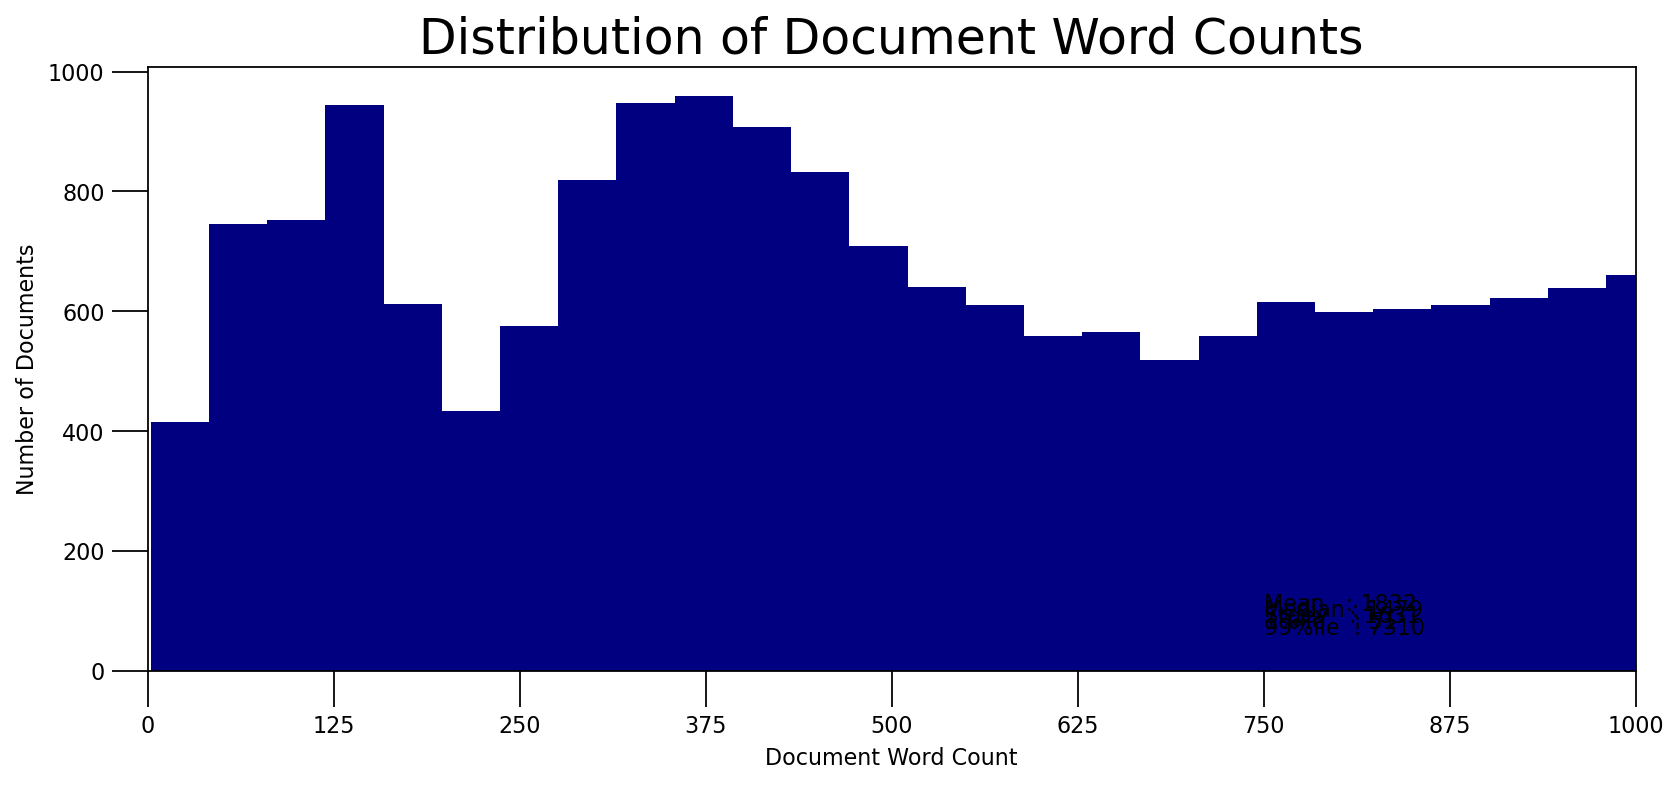

In [42]:
plt.figure(figsize=(12,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

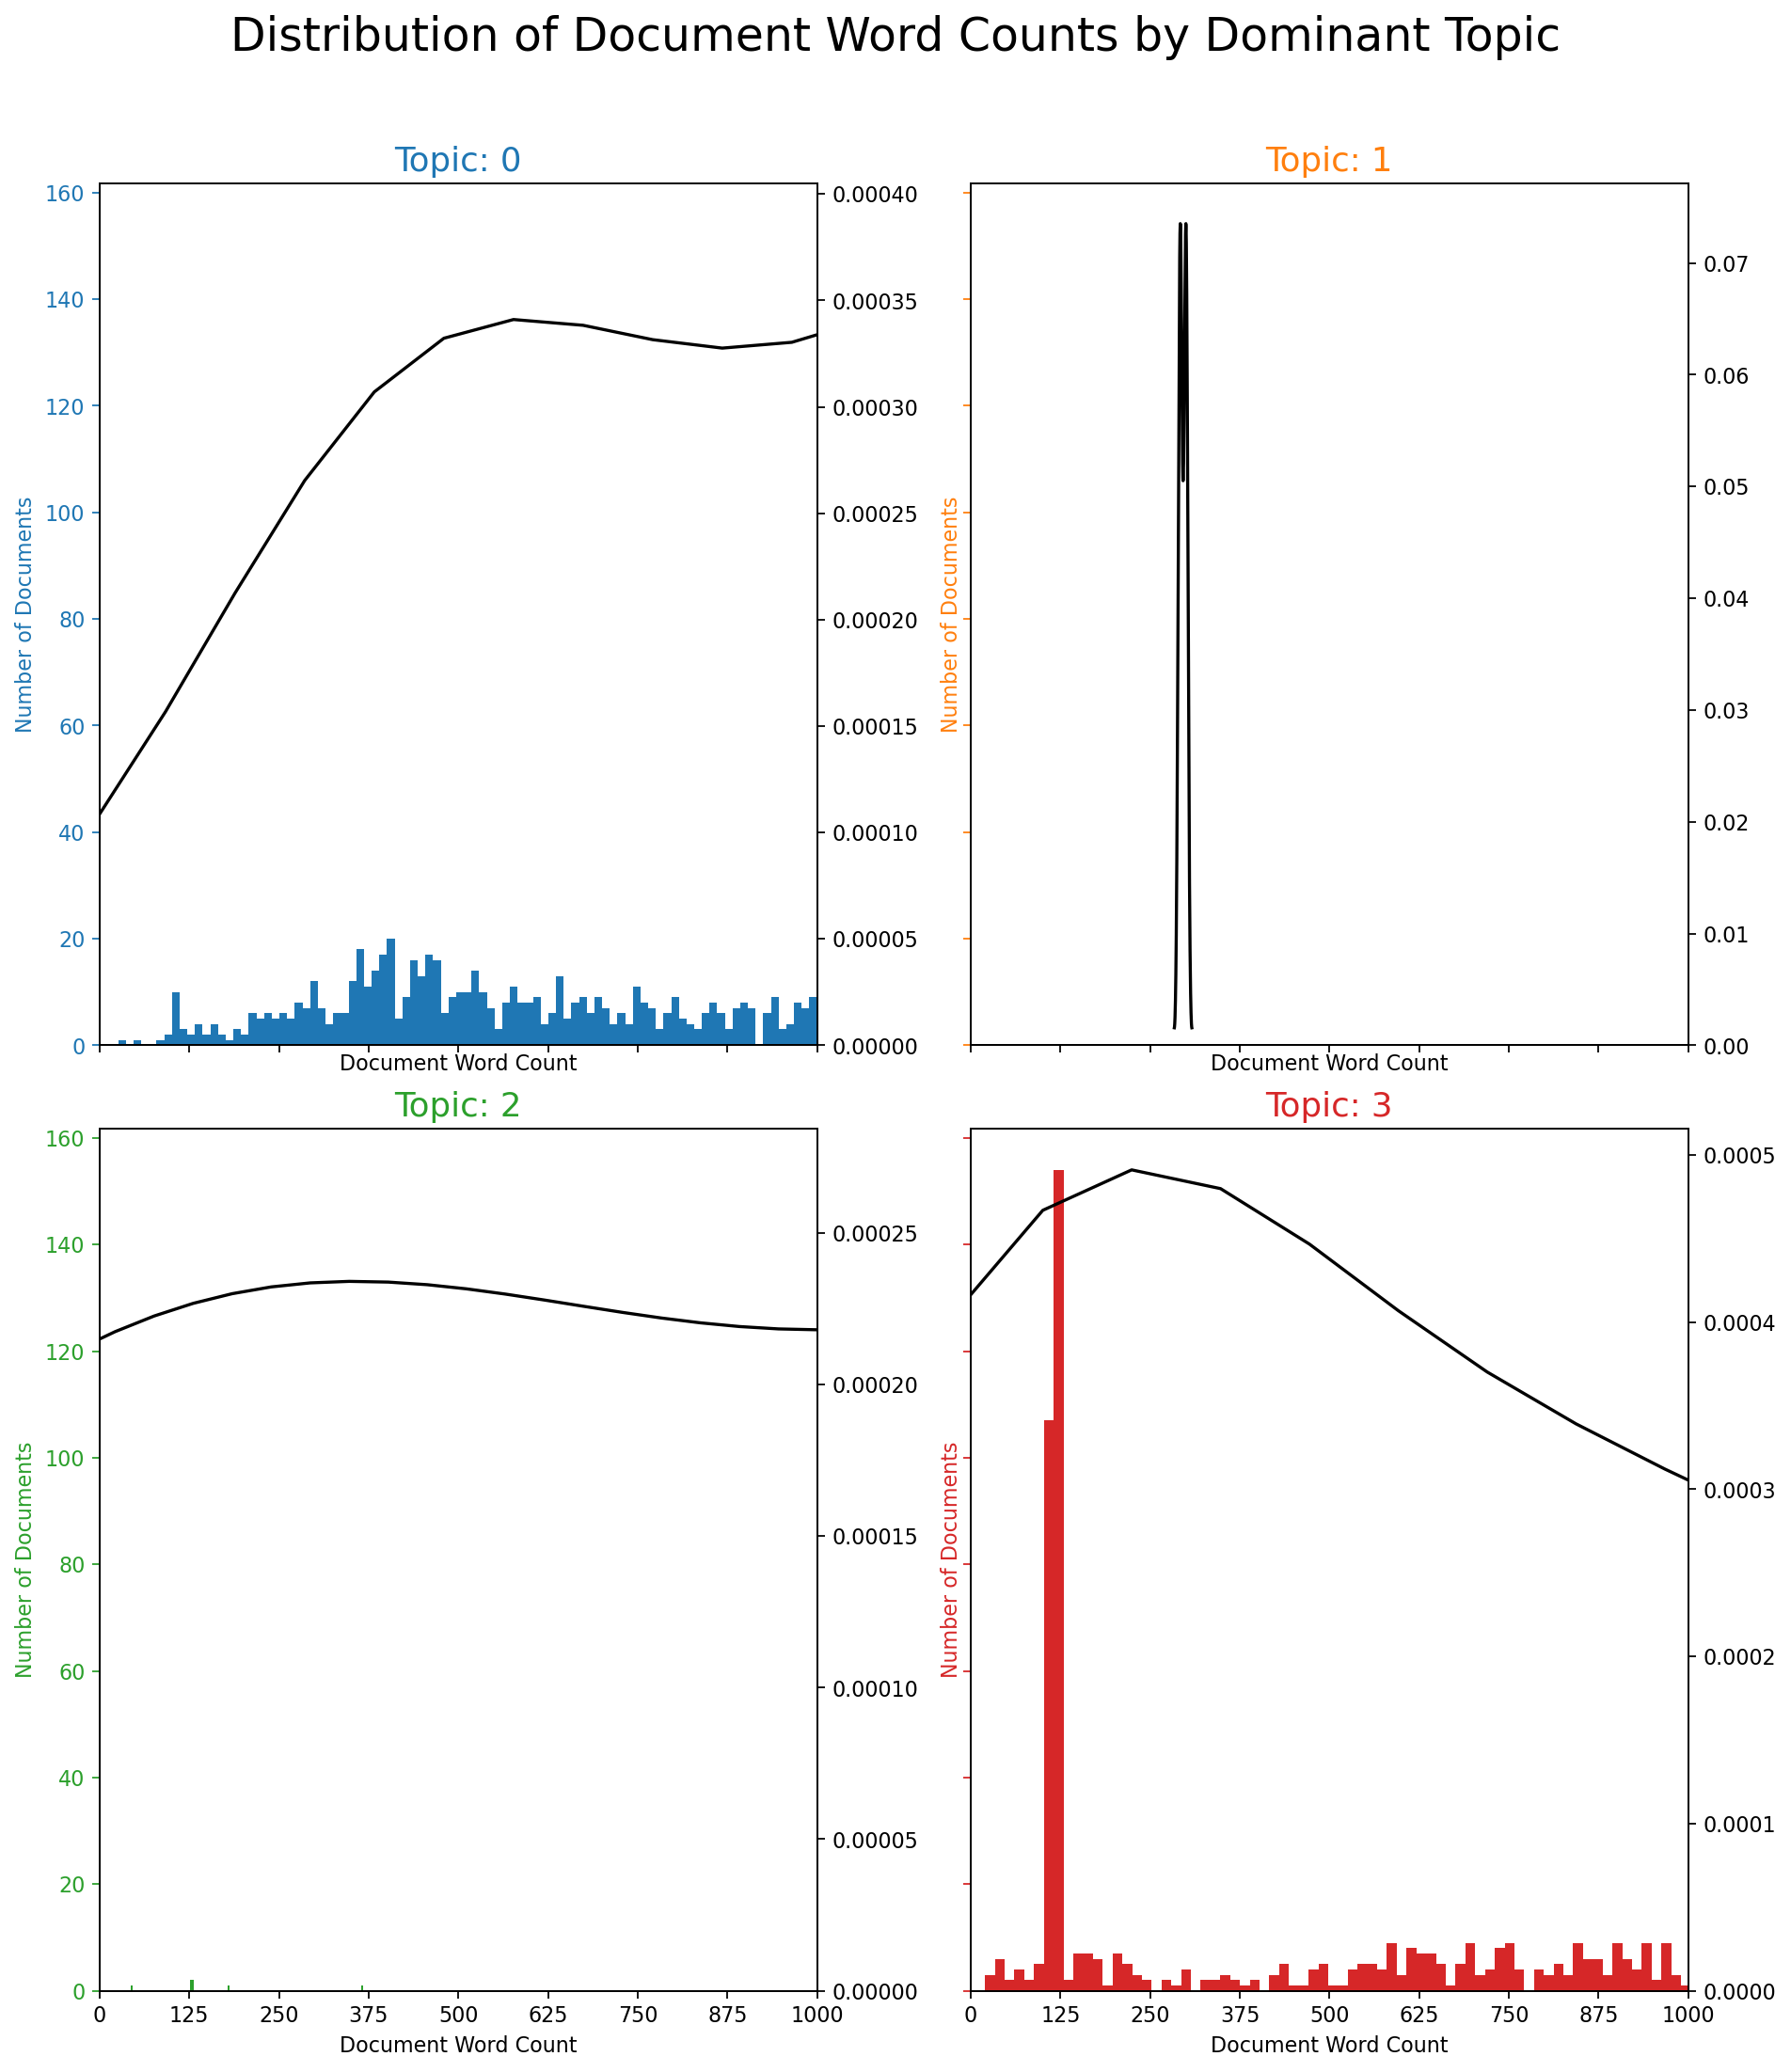

In [43]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(12,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

***
**Word Clouds of Top N Keywords in Each Topic**
***

In [44]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

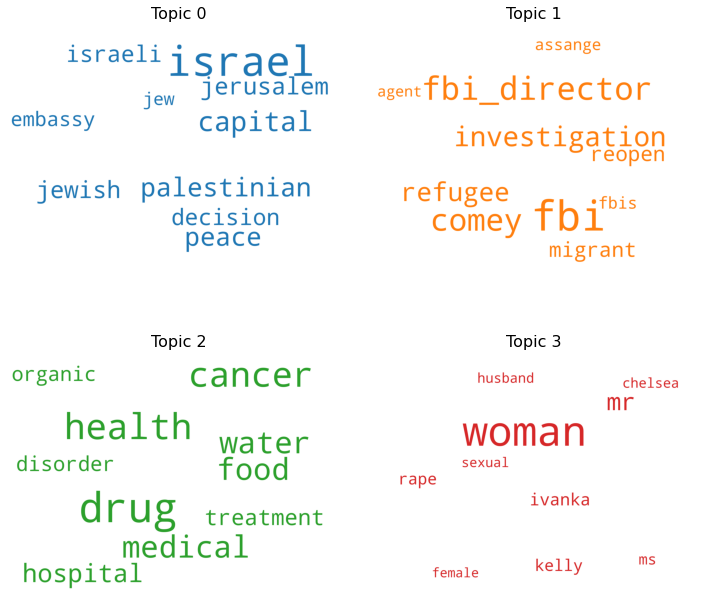

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

***
**Word Counts of Topic Keywords**
****

In [46]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

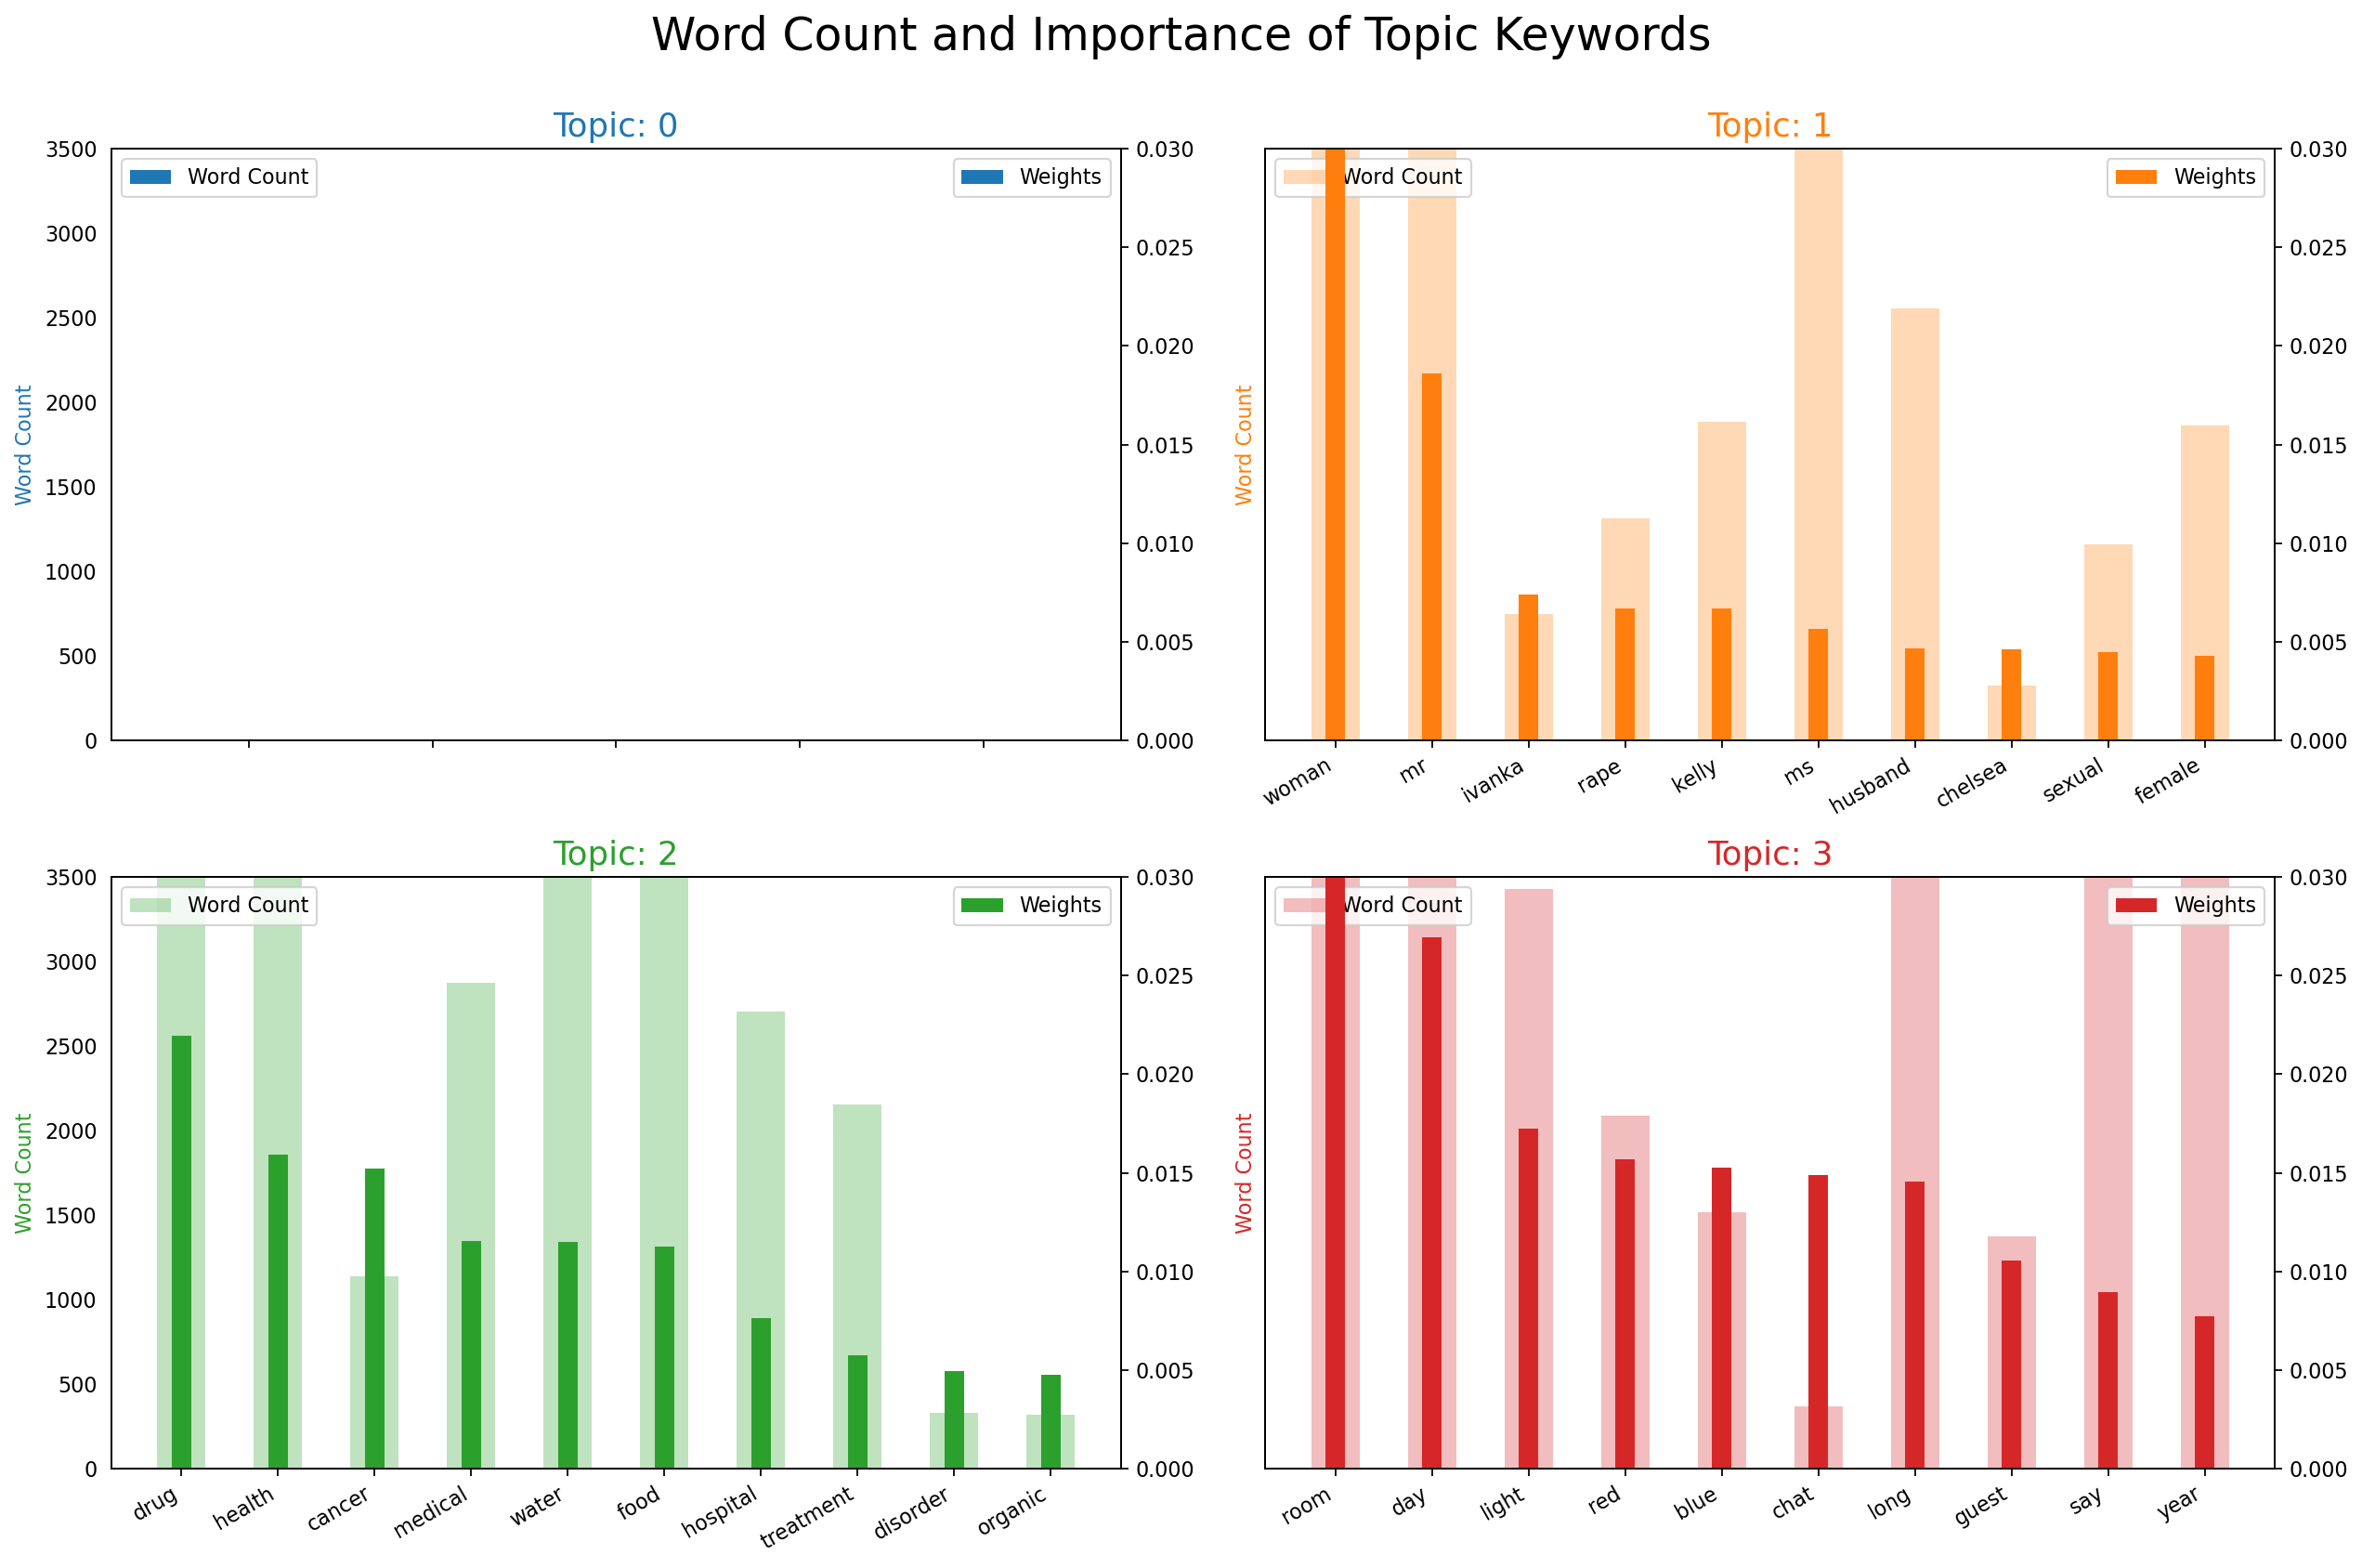

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

***
**t-SNE Clustering Chart**
***

In [49]:
# Get topic weights and dominant topics 
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 31825 samples in 0.001s...
[t-SNE] Computed neighbors for 31825 samples in 31.929s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31825
[t-SNE] Computed conditional probabilities for sample 2000 / 31825
[t-SNE] Computed conditional probabilities for sample 3000 / 31825
[t-SNE] Computed conditional probabilities for sample 4000 / 31825
[t-SNE] Computed conditional probabilities for sample 5000 / 31825
[t-SNE] Computed conditional probabilities for sample 6000 / 31825
[t-SNE] Computed conditional probabilities for sample 7000 / 31825
[t-SNE] Computed conditional probabilities for sample 8000 / 31825
[t-SNE] Computed conditional probabilities for sample 9000 / 31825
[t-SNE] Computed conditional probabilities for sample 10000 / 31825
[t-SNE] Computed conditional probabilities for sample 11000 / 31825
[t-SNE] Computed conditional probabilities for sample 12000 / 31825
[t-SNE] Computed conditional probabilities for sa

In [69]:
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

In [71]:
# Plot the Topic Clusters using Bokeh
output_notebook()

plot = figure(title="t-SNE Clustering", 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...